In [1]:
import gym
from itertools import count #一个高效的迭代器
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v1')
env.seed(42)
gamma = 0.9
torch.manual_seed(2) #为CPU设备设置种子用于生成随机数，让torch.rand(n)每次生成的随机数是确定的

In [6]:
#Policy 网络
class Policy(nn.Module):
    def __init__(self):
        #引用nn.Module的__init__()，等价于nn.Module.__init(self)
        super(Policy,self).__init__()
        self.Line1 = nn.Linear(4,128)
        self.dropout = nn.Dropout(p=0.5)
        self.Line2 = nn.Linear(128,2)
        
        self.saved_log_probs = []
        self.rewards = []
    
    def forward(self,x):
        x = self.Line1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.Line2(x)
        softmax_scores = F.softmax(action_scores,dim=1)
        return softmax_scores

In [7]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(),lr=1e-2)
eps = np.finfo(np.float32).eps.item()     #自然对数e

In [5]:
def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)                             #对probs求自然对数
    action = m.sample()                                #对自然对数m进行sample，返回索引值
    policy.saved_log_probs.append(m.log_prob(action))  #存储被sample到的action的对数值
    return action.item()

In [6]:
def finish_episode():
    policy_loss = []
    R = 0
    returns = []
    for r in policy.rewards[::-1]:
        R = r + R*gamma
        returns.insert(0,R)
    returns = torch.tensor(returns)
    returns = (returns -returns.mean())/(returns.std() + eps)# +eps??
    for log_prob, R in zip(policy.saved_log_probs,returns):
        policy_loss.append(-log_prob*R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    #清空数据
    del policy.rewards[:]
    del policy.saved_log_probs[:]

In [7]:
def plot_reward(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.title('frame %s. mean_reward: %s'%(frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.xlabel('epoch')
    plt.ylabel('reward')
    plt.show()

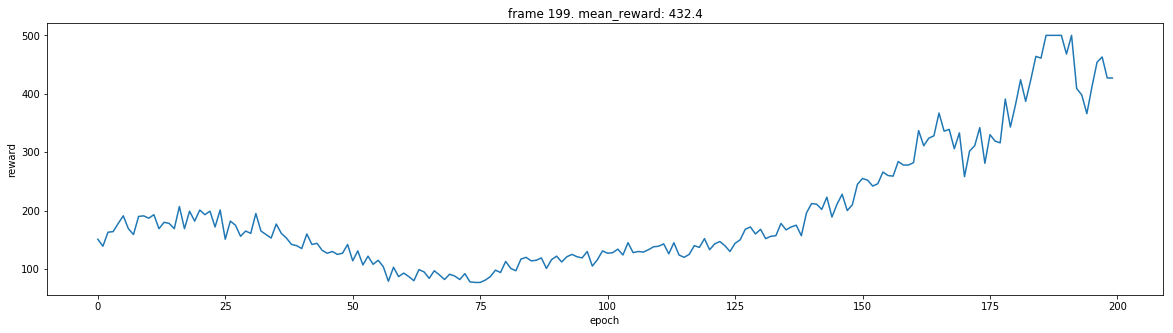

In [11]:
running_reward = []
for episode in range(200):
    state, ep_reward = env.reset(), 0
    for i in range(1,10000):
        action = select_action(state)
        state, reward, done, _ = env.step(action)
        policy.rewards.append(reward)
        ep_reward += reward
        if done:
            break
    running_reward.append(ep_reward)
    finish_episode()
    plot_reward(episode,running_reward)

CartPole-v1环境: action正确,reward=1;action错误,reward=0

1.Policy():定义神经网络结构

2.select_action:定义选择动作函数(对每次进行sample的action概率取对数，并记录:$log(\pi(s_i,a_i))$

3.finish_episode:定义更新操作,计算出Baseline-R，将每次的-R*log_prob计算求和，计算loss.sum()进行反向传递更新

4.训练: 先sample一个序列 P $<log\pi(s_1,a_1)),R_1,\dots,log(\pi(s_n,a_n)),R_n>$，调用finish_episode()函数

更新规则:
$$
\theta_{t+1} = \theta_t +\alpha \frac{\hat{A}(s,a)\nabla\pi_{\theta_t}(a|s)}{\pi_\theta(a|s)}\\
\theta_{t+1} = \theta_t +\alpha\hat{A}(s,a)\nabla_\theta \log\pi_\theta(s|a)
$$
Loss function:
$$
\sum(-\hat{A}(s,a)\log\pi(s|a))
$$
1.$\hat{A}(s,a)$为advantage function,$\pi_\theta(s|a)$为在s采取动作a的可能性，可将其导数理解为在s采取动作a这个向量。

2.除上$\pi_\theta(a|s)$是因为让小概率的动作获得较大的增长空间(增长可正可负)

3.理解loss function:对loss求导才会有更新操作，所以Loss中没有求导

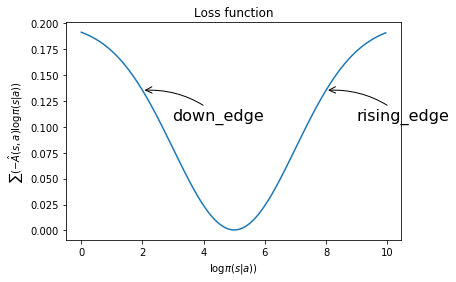

In [9]:
x = np.arange(0,10,0.05)
mu, sigma = 5, 2
y = lambda x : -np.exp(-((x-mu)**2)/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))+0.2
plt.plot(x, y(x))
plt.title("Loss function")
plt.xlabel("$\log\pi(s|a))$")
plt.ylabel("$\sum(-\hat{A}(s,a)\log\pi(s|a))$")
plt.annotate(r'rising_edge',xy=(8,y(8)), xycoords='data', xytext=(+30, -30),
             textcoords='offset points', fontsize=16,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))
plt.annotate(r'down_edge',xy=(2,y(2)), xycoords='data', xytext=(+30, -30),
             textcoords='offset points', fontsize=16,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))
plt.show()

* policy gradient 可以很好的处理连续状态：

    神经网络可以很好的映射:从某个state$\rightarrow$action
    
    
* 对更新的理解

    到最后Loss可以收敛一个趋近于0的值: 考虑到公式$-\hat{A}log\pi(s,a)$，开始训练时$\hat{A}$大的可能少sample，$log\pi(s,a)$会较小(取反会较大)，此时在通过更新Loss Function找到global optimum。$\hat{A}$小的会少sample，$log\pi(s,a)$会较小(取反会较大)、$\hat{A}$大的会多sample，$log\pi(s,a)$会较大(取反会较小)，所以稳定状态总的Loss是趋于0的，也就是说此时的神经网络参数基本稳定。但训练过程中会出现从最高的reward变为较小的reward的现象，可以宏观的理解为可能只达到了local optimum,也就是有些state和action没有搜索到
    
    
* 对连续动作的理解
    
    状态动作概率映射函数$\pi(s,a)$本身就可以理解为在某个state从$action\rightarrow\pi(s,a)$的映射,具体可如下图抽象理解


* 对$\Delta\pi(s,a)$的理解(先不除$\pi(s,a)$)

    此时是对单个state进行考虑,所以横坐标为action的映射，所以沿着导数的方向就可以找到$\pi_(s,a)$最大的action

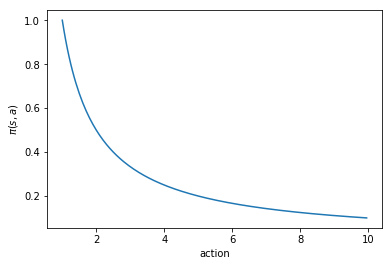

In [10]:
x = np.arange(1,10,0.05)
y = 1/x
plt.xlabel("action")
plt.ylabel("$\pi(s,a)$")
plt.plot(x,y)
plt.show()